Importing necesssary libraries:

In [27]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from os import listdir
from PIL import Image as PImage
import cv2

## Loading and Visualizing the Data

In [28]:
num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

## Visualizing a Batch Of Training Data

C:\Users\bodem\AppData\Local\Temp/ipykernel_24912/510816729.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


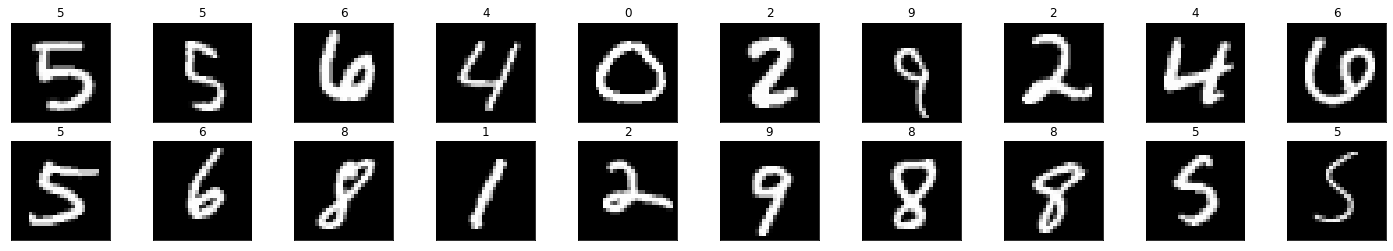

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

## Viewing an Image in More Detail

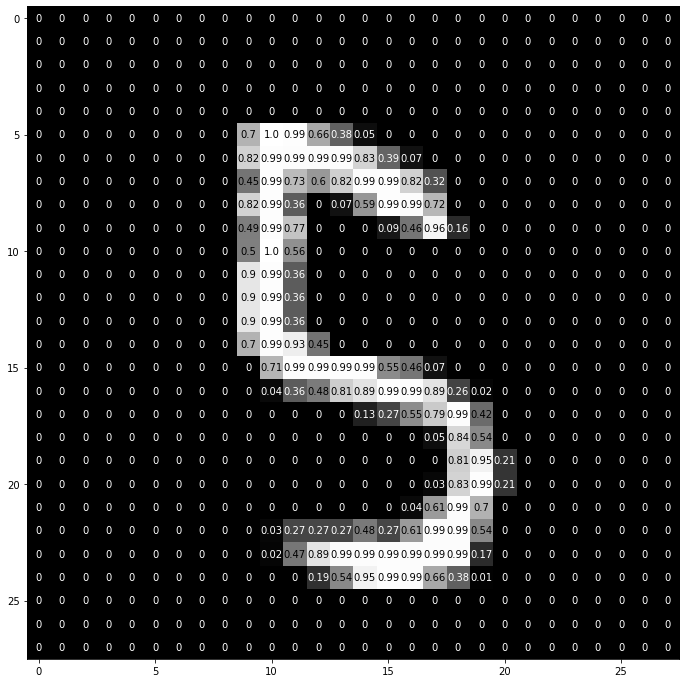

In [30]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Defining the Network Architecture 

In [31]:
import torch.nn as nn
import torch.nn.functional as F

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
       
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [33]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Training the Network

In [34]:
epochs = 50

valid_loss_min = np.Inf

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format( valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.938841 	Validation Loss: 0.375748
Validation loss decreased (inf --> 0.375748).  Saving model ...
Epoch: 2 	Training Loss: 0.350305 	Validation Loss: 0.288720
Validation loss decreased (0.375748 --> 0.288720).  Saving model ...
Epoch: 3 	Training Loss: 0.276627 	Validation Loss: 0.238272
Validation loss decreased (0.288720 --> 0.238272).  Saving model ...
Epoch: 4 	Training Loss: 0.230415 	Validation Loss: 0.205678
Validation loss decreased (0.238272 --> 0.205678).  Saving model ...
Epoch: 5 	Training Loss: 0.195852 	Validation Loss: 0.176618
Validation loss decreased (0.205678 --> 0.176618).  Saving model ...
Epoch: 6 	Training Loss: 0.171014 	Validation Loss: 0.158612
Validation loss decreased (0.176618 --> 0.158612).  Saving model ...
Epoch: 7 	Training Loss: 0.151455 	Validation Loss: 0.141738
Validation loss decreased (0.158612 --> 0.141738).  Saving model ...
Epoch: 8 	Training Loss: 0.134778 	Validation Loss: 0.130190
Validation loss decreased (0.14173

In [35]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Testing the Network:

In [36]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % ( 100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.058248

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 98% (1015/1032)
Test Accuracy of     3: 98% (997/1010)
Test Accuracy of     4: 98% (966/982)
Test Accuracy of     5: 98% (875/892)
Test Accuracy of     6: 98% (943/958)
Test Accuracy of     7: 97% (1001/1028)
Test Accuracy of     8: 97% (947/974)
Test Accuracy of     9: 97% (985/1009)

Test Accuracy (Overall): 98% (9824/10000)


## Visualizing Sample Test Results

C:\Users\bodem\AppData\Local\Temp/ipykernel_24912/3881842749.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


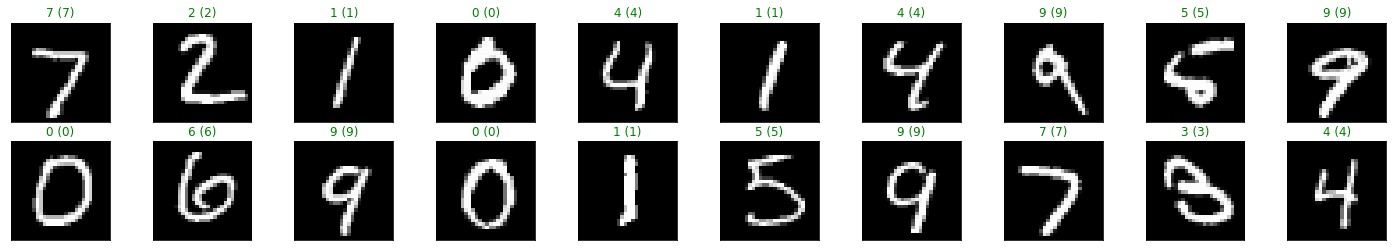

In [65]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

C:\Users\bodem\AppData\Local\Temp/ipykernel_24912/3066525134.py:40: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


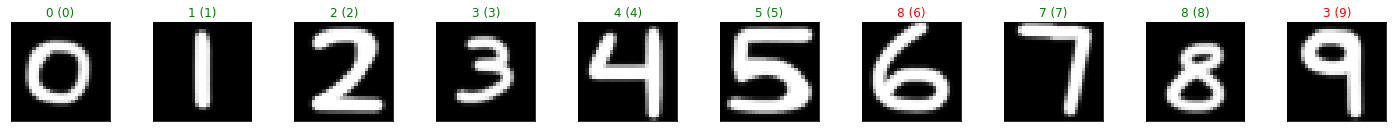

In [64]:
path = "data/MNIST/raw/images/"
imagesList = listdir(path)
loadedImages = []
tests = []

correct = []

for image in imagesList:
    img = PImage.open(path + image).convert('L')
    loadedImages.append(img)

    correct.append(image.split('.')[0])
    
    img = np.array(img)

    width, height = img.shape
    thresh = img.max()/2.5

    imgCopy = np.asarray(img)
    imgCopy = imgCopy.astype(float)

    for x in range(width):
        for y in range(height):
            imgCopy[x][y] = float(img[x][y]/255.0)
            val = round(imgCopy[x][y],2) if imgCopy[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if imgCopy[x][y]<thresh else 'black')
    tests.append(imgCopy)
    
tests = torch.from_numpy(np.array(tests))

output = model(tests.float())
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(len(imagesList)):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(tests[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(correct[idx])), color=("green" if str(preds[idx].item()) == str(correct[idx]) else "red"))
